# Proceso Modelamiento ML Ops - Yahoo Finance - Nvidia
## Realizado por Daniel Muñoz Palma

In [ ]:
#!pip install yfinance -q

In [ ]:
#!pip install prophet -q

## Librerias

In [1]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
from datetime import datetime, timedelta
import numpy as np
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error

C:\Users\lenovo\.conda\envs\DeepLearningPrueba\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Punto: Extraer datos históricos de la compañía Nvidia y sus componentes desde Yahoo Finance utilizando Python

In [2]:
# Fechas: últimos 10 años
end_date = datetime.today()
start_date = end_date - timedelta(days=365*10)

In [3]:
nvda = yf.download("NVDA", start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"), progress=True, group_by=None)
#2. Aplanar columnas si aún vienen con multiíndice

if isinstance(nvda.columns, pd.MultiIndex):
    nvda.columns = nvda.columns.get_level_values(1)

#3. Quitar nombres de columnas y resetear índice
nvda.columns.name = None
nvda.reset_index(inplace=True)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_15372\1975095903.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvda = yf.download("NVDA", start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"), progress=True, group_by=None)
[*********************100%***********************]  1 of 1 completed


In [77]:
nvda.head()

,Date,Open,High,Low,Close,Volume
0,2015-06-22,0.530248,0.533152,0.519116,0.527102,514236000
1,2015-06-23,0.528070,0.532184,0.509435,0.513550,414064000
2,2015-06-24,0.512824,0.515486,0.506047,0.508467,253368000
3,2015-06-25,0.508467,0.515486,0.508467,0.512339,350460000
4,2015-06-26,0.508225,0.508709,0.499755,0.501933,421296000


In [78]:
df = nvda.reset_index()[['Date', 'Close']]

In [79]:
df.head()

,Date,Close
0,2015-06-22,0.527102
1,2015-06-23,0.513550
2,2015-06-24,0.508467
3,2015-06-25,0.512339
4,2015-06-26,0.501933


In [80]:
# Aseguremos que la varibale date tenga el formato fecha
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

In [81]:
df.set_index('Date', inplace=True)

In [82]:
df = data_excel.asfreq('D')

In [83]:
df.index

DatetimeIndex(['2015-06-22', '2015-06-23', '2015-06-24', '2015-06-25',
               '2015-06-26', '2015-06-27', '2015-06-28', '2015-06-29',
               '2015-06-30', '2015-07-01',
               ...
               '2025-06-09', '2025-06-10', '2025-06-11', '2025-06-12',
               '2025-06-13', '2025-06-14', '2025-06-15', '2025-06-16',
               '2025-06-17', '2025-06-18'],
              dtype='datetime64[ns]', name='Date', length=3650, freq='D')

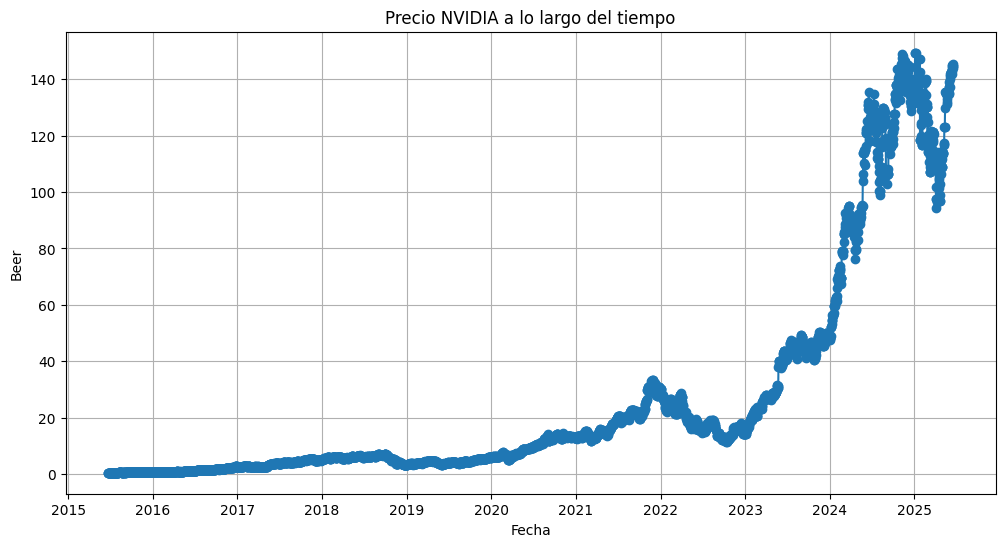

In [84]:
import matplotlib.pyplot as plt # Es una biblioteca en Python utilizada para crear gráficos y visualizaciones de datos de manera fácil y flexible.

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], marker='o', linestyle='-')
plt.title('Precio NVIDIA a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Beer')
plt.grid(True)
plt.show()

In [85]:
# Contemos cuanto periodos tienen datos faltantes
df.isna().sum()

Close    0
dtype: int64

In [86]:
df.Close=df.Close.fillna(method='bfill')

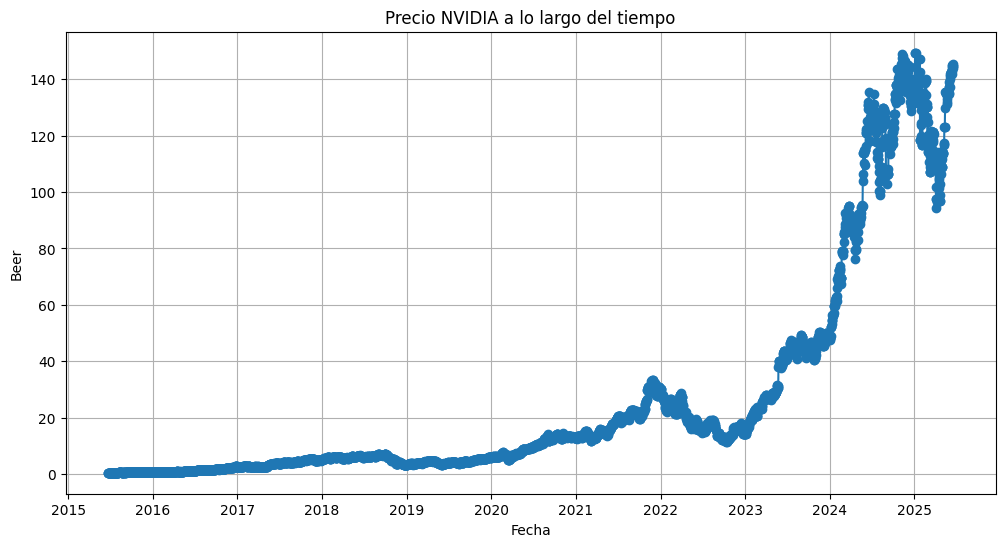

In [87]:
import matplotlib.pyplot as plt # Es una biblioteca en Python utilizada para crear gráficos y visualizaciones de datos de manera fácil y flexible.

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], marker='o', linestyle='-')
plt.title('Precio NVIDIA a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Beer')
plt.grid(True)
plt.show()

# Descomposición de la serie

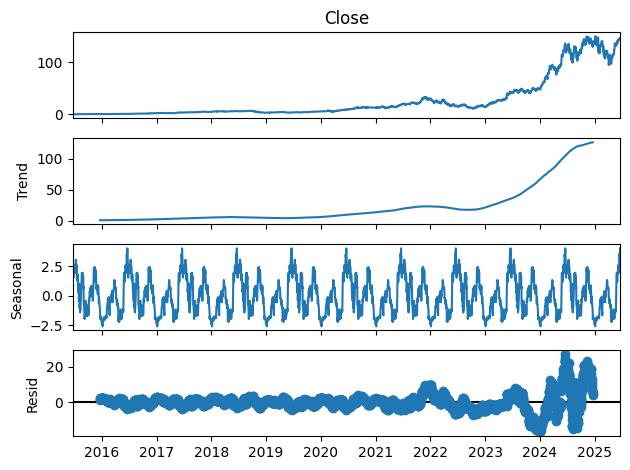

In [88]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df["Close"], model='additive', period=365)

# Graficar los componentes
result.plot()
plt.show()

In [89]:
from statsmodels.tsa.stattools import adfuller

resultado_adf = adfuller(df["Close"])

print("Prueba Dickey-Fuller Aumentada (ADF):")
print(f"Estadístico de Prueba: {resultado_adf[0]:.4f}")
print(f"P-valor: {resultado_adf[1]:.4f}")
#print(f"Valores Críticos: {resultado_adf[4]}")
if resultado_adf[1] < 0.05:
    print("La serie es estacionaria (se rechaza la hipótesis nula).")
else:
    print("La serie NO es estacionaria (no se rechaza la hipótesis nula).")

Prueba Dickey-Fuller Aumentada (ADF):
Estadístico de Prueba: 1.8033
P-valor: 0.9984
La serie NO es estacionaria (no se rechaza la hipótesis nula).


In [90]:
df["Diferenciada"] = df["Close"].diff().dropna()

In [91]:
df

,Close,Diferenciada
Date,,
2015-06-22,0.527102,NaN
2015-06-23,0.513550,-0.013553
2015-06-24,0.508467,-0.005082
2015-06-25,0.512339,0.003872
2015-06-26,0.501933,-0.010406
...,...,...
2025-06-14,144.690002,2.720001
2025-06-15,144.690002,0.000000
2025-06-16,144.690002,0.000000


In [101]:
clean_data = df["Diferenciada"].replace([np.inf, -np.inf], np.nan).dropna()

# Run ADF test
resultado_adf = adfuller(clean_data)

print("Prueba Dickey-Fuller Aumentada (ADF):")
print(f"Estadístico de Prueba: {resultado_adf[0]:.4f}")
print(f"P-valor: {resultado_adf[1]:.4f}")
print("Valores Críticos:")
for key, value in resultado_adf[4].items():
    print(f"\t{key}: {value:.4f}")

# Hypothesis test interpretation
if resultado_adf[1] < 0.05:
    print("La serie es estacionaria (se rechaza la hipótesis nula de no estacionariedad).")
else:
    print("La serie NO es estacionaria (no se rechaza la hipótesis nula).")

Prueba Dickey-Fuller Aumentada (ADF):
Estadístico de Prueba: -12.0442
P-valor: 0.0000
Valores Críticos:
	1%: -3.4322
	5%: -2.8623
	10%: -2.5672
La serie es estacionaria (se rechaza la hipótesis nula de no estacionariedad).


In [96]:
from statsmodels.stats.diagnostic import acorr_ljungbox

resultado_ljung = acorr_ljungbox(df["Diferenciada"].dropna(), lags=[10], return_df=True)

print("Prueba de Ljung-Box:")
print(resultado_ljung)

if resultado_ljung['lb_pvalue'].values[0] < 0.05:
    print("✅ Hay evidencia de autocorrelación en la serie (se rechaza la independencia).")
else:
    print("❌ No hay evidencia de autocorrelación significativa.")

Prueba de Ljung-Box:
       lb_stat     lb_pvalue
10  149.279329  5.243921e-27
✅ Hay evidencia de autocorrelación en la serie (se rechaza la independencia).


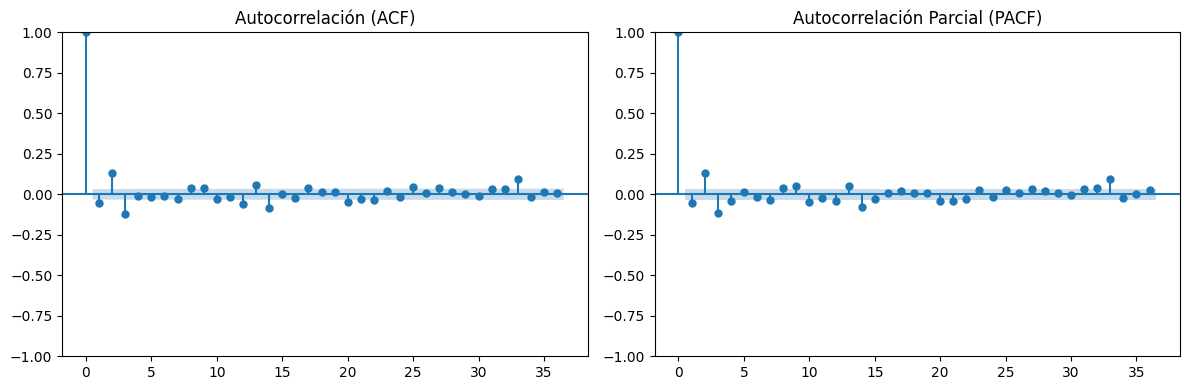

In [102]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de autocorrelación (ACF)
plot_acf(df["Diferenciada"].dropna(), ax=axes[0], lags=36)
axes[0].set_title("Autocorrelación (ACF)")

# Gráfico de autocorrelación parcial (PACF)
plot_pacf(df["Diferenciada"].dropna(), ax=axes[1], lags=36)
axes[1].set_title("Autocorrelación Parcial (PACF)")

plt.tight_layout()
plt.show()

## Modelo Prohet

In [34]:
df = nvda.reset_index()[['Date', 'Close']]

In [35]:
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
df['ds'] = df['ds'].dt.tz_localize(None)

In [36]:
df

,ds,y
0,2015-06-22,0.527102
1,2015-06-23,0.513550
2,2015-06-24,0.508467
3,2015-06-25,0.512339
4,2015-06-26,0.501933
...,...,...
2509,2025-06-12,145.000000
2510,2025-06-13,141.970001
2511,2025-06-16,144.690002
2512,2025-06-17,144.119995


In [38]:
m = Prophet()  # ajusta el modelo automaticamente
#m.add_country_holidays(country_name='CO')  # 'CO' = Código ISO de Colombia
m.fit(df)

23:36:01 - cmdstanpy - INFO - Chain [1] start processing
23:36:04 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
future = m.make_future_dataframe(periods=30,freq = 'd')

In [40]:
future.head()

,ds
0,2015-06-22
1,2015-06-23
2,2015-06-24
3,2015-06-25
4,2015-06-26


In [41]:
forecast = m.predict(future)

In [42]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-06-22,-0.506272,-7.817863,10.998595,-0.506272,-0.506272,2.600273,2.600273,2.600273,-0.183188,-0.183188,-0.183188,2.783461,2.783461,2.783461,0.0,0.0,0.0,2.094001
1,2015-06-23,-0.500300,-6.927512,12.040597,-0.500300,-0.500300,2.563410,2.563410,2.563410,-0.220042,-0.220042,-0.220042,2.783451,2.783451,2.783451,0.0,0.0,0.0,2.063110
2,2015-06-24,-0.494327,-7.184547,11.921511,-0.494327,-0.494327,2.515333,2.515333,2.515333,-0.272175,-0.272175,-0.272175,2.787508,2.787508,2.787508,0.0,0.0,0.0,2.021007
3,2015-06-25,-0.488354,-7.384908,11.844661,-0.488354,-0.488354,2.610621,2.610621,2.610621,-0.186094,-0.186094,-0.186094,2.796715,2.796715,2.796715,0.0,0.0,0.0,2.122267
4,2015-06-26,-0.482382,-8.199298,11.897126,-0.482382,-0.482382,2.636949,2.636949,2.636949,-0.174905,-0.174905,-0.174905,2.811854,2.811854,2.811854,0.0,0.0,0.0,2.154567


In [43]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
2532,2025-07-07,158.590182,149.022837,167.847394
2533,2025-07-08,158.737972,150.237874,168.293814
2534,2025-07-09,158.859723,149.516929,168.060866
2535,2025-07-10,159.107119,149.735975,168.592919
2536,2025-07-11,159.265463,149.493057,168.590037
2537,2025-07-12,160.090246,150.509040,169.447632
2538,2025-07-13,160.205445,150.258725,169.664119
2539,2025-07-14,159.602146,149.517423,168.770447
2540,2025-07-15,159.646034,150.039840,169.264299
2541,2025-07-16,159.657466,150.061113,169.136583


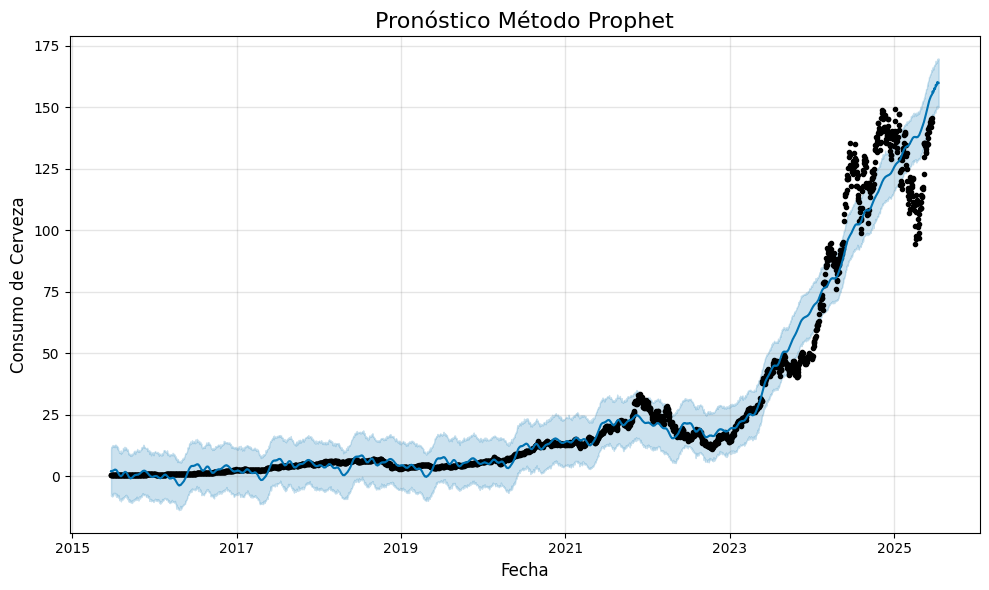

In [44]:
# Generar el gráfico base con Prophet (usa Matplotlib)
fig = m.plot(forecast)

# Acceder al eje principal del gráfico
ax = fig.gca()

# Agregar título y etiquetas a los ejes
ax.set_title("Pronóstico Método Prophet", fontsize=16)
ax.set_xlabel("Fecha", fontsize=12)
ax.set_ylabel("Consumo de Cerveza", fontsize=12)

# Mostrar el gráfico
plt.tight_layout()

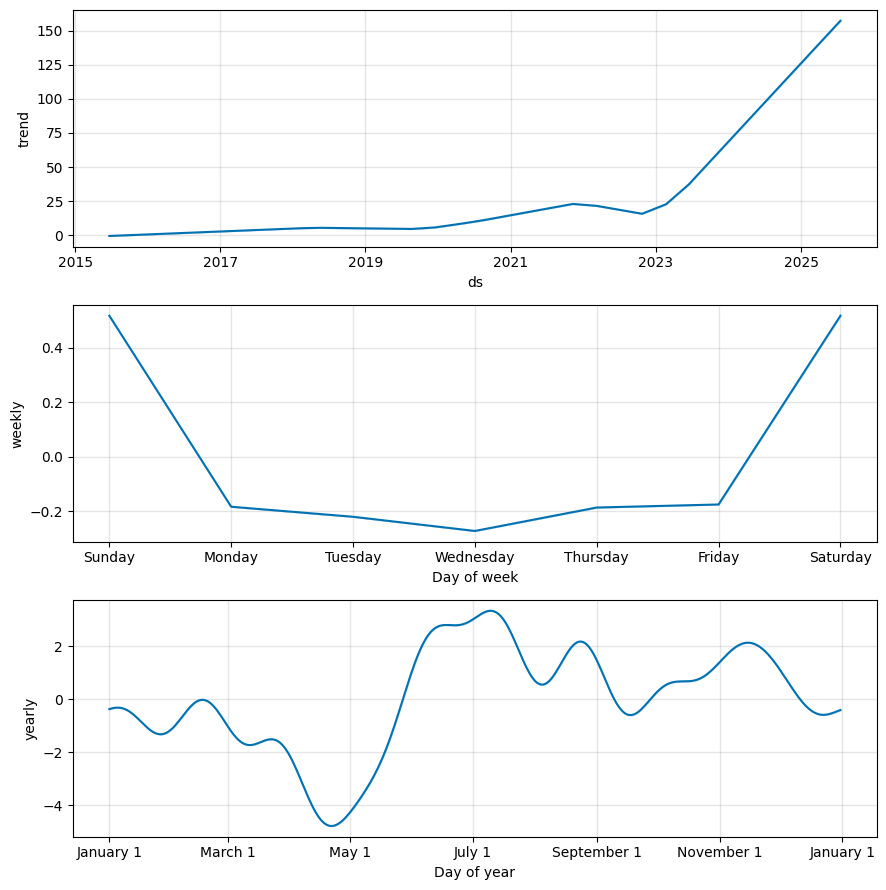

In [45]:
m.plot_components(forecast);

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import display, Markdown

df['yhat'] = forecast['yhat']

In [51]:
# Calcular errores
mae = mean_absolute_error(df['y'], df['yhat'])
mse = mean_squared_error(df['y'], df['yhat'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(df['y'], df['yhat'])

# Crear tabla
tabla_errores = pd.DataFrame({
    'Error': ['MAE', 'MSE', 'RMSE', 'MAPE'],
    'Valor': [mae, mse, rmse, mape]
})

display(Markdown("### Tabla de los errores Método Prophet"))
tabla_errores

### Tabla de los errores Método Prophet

,Error,Valor
0,MAE,4.164513
1,MSE,56.375079
2,RMSE,7.508334
3,MAPE,0.433073


## Random Forest

In [53]:
import mlflow
import mlflow.sklearn  # Para modelos de sklearn


import yfinance as yf
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuración
TICKER = "NVDA"
YEARS_OF_DATA = 10
FORECAST_DAYS = 30
TEST_DAYS = 30

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {
        'MAE': round(mae, 4),
        'MSE': round(mse, 4),
        'RMSE': round(rmse, 4),
        'MAPE (%)': round(mape, 4)
    }

def download_stock_data():
    end_date = datetime.now()
    start_date = end_date - timedelta(days=YEARS_OF_DATA * 365)
    data = yf.download(TICKER, start=start_date, end=end_date, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    print(f" Columnas descargadas: {data.columns}")
    print(f" Tamaño del dataset: {data.shape}")
    price_column = 'Close' if 'Close' in data.columns else 'Adj Close'
    return data, price_column

def prepare_data(data, price_column):
    df = data[[price_column]].copy()
    df = df.reset_index()
    df.columns = ['ds', 'y']
    df['ds'] = pd.to_datetime(df['ds'])
    df['y'] = pd.to_numeric(df['y'], errors='coerce')
    df.dropna(inplace=True)
    return df

def build_features(df):
    # Convertimos la fecha a ordinal para que RF la entienda
    df['ds_ordinal'] = df['ds'].map(datetime.toordinal)
    return df[['ds', 'ds_ordinal', 'y']]

def forecast_future_dates(df, model):
    last_date = df['ds'].max()
    future_dates = [last_date + timedelta(days=i) for i in range(1, FORECAST_DAYS + 1)]
    future_ordinals = [d.toordinal() for d in future_dates]
    
    X_future = pd.DataFrame({'ds': future_dates, 'ds_ordinal': future_ordinals})
    X_pred = X_future[['ds_ordinal']]
    y_pred = model.predict(X_pred)
    
    future_forecast = X_future.copy()
    future_forecast['yhat'] = y_pred
    return future_forecast

def save_results(forecast, metrics):
    os.makedirs("forecasts", exist_ok=True)
    today = datetime.now().strftime("%Y%m%d")
    
    forecast.to_csv(f"forecasts/nvda_forecast_rf_{today}.csv", index=False)
    pd.DataFrame([metrics]).to_csv(f"forecasts/nvda_metrics_rf_{today}.csv", index=False)
    with open(f"forecasts/metrics_log_rf_{today}.txt", "w") as f:
        for k, v in metrics.items():
            f.write(f"{k}: {v}\n")

if __name__ == "__main__":
    try:
        print(" Descargando datos...")
        data, price_column = download_stock_data()
        print(f" Usando columna de precios: {price_column}")
        
        df = prepare_data(data, price_column)
        df = build_features(df)

        print(" Separando en entrenamiento y prueba...")
        train = df[:-TEST_DAYS]
        test = df[-TEST_DAYS:]

        X_train = train[['ds_ordinal']]
        y_train = train['y']
        X_test = test[['ds_ordinal']]
        y_test = test['y']

        print(" Entrenando modelo Random Forest...")
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        print(" Generando predicciones...")
        y_pred_test = model.predict(X_test)
        metrics = calculate_metrics(y_test, y_pred_test)

        # Forecast de los próximos 30 días
        future_forecast = forecast_future_dates(df, model)

        print("\n Métricas de Error:")
        for k, v in metrics.items():
            print(f"{k}: {v}")

        save_results(future_forecast, metrics)
        print("\n Resultados guardados en /forecasts/")

    except Exception as e:
        print(f"\n Error: {str(e)}")

 Descargando datos...


C:\Users\lenovo\AppData\Local\Temp\ipykernel_15372\3632754105.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=start_date, end=end_date, progress=False)


 Columnas descargadas: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
 Tamaño del dataset: (2513, 5)
 Usando columna de precios: Close
 Separando en entrenamiento y prueba...
 Entrenando modelo Random Forest...
 Generando predicciones...

 Métricas de Error:
MAE: 22.3196
MSE: 563.7425
RMSE: 23.7433
MAPE (%): 16.1202

 Resultados guardados en /forecasts/


In [103]:
import mlflow
import mlflow.sklearn
import yfinance as yf
import pandas as pd
import numpy as np
import os
import warnings
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Yahoo Finance - Pronosticos 
TICKER = "NVDA"
YEARS_OF_DATA = 10
FORECAST_DAYS = 30
TEST_DAYS = 30

def calculate_metrics(y_true, y_pred):
    """Calcula métricas de evaluación"""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    return {
        'MAE': round(mae, 4),
        'MSE': round(mse, 4),
        'RMSE': round(np.sqrt(mse), 4),
        'MAPE_percent': round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 4)
    }

def download_stock_data():
    """Descarga datos históricos del ticker"""
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365 * YEARS_OF_DATA)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = yf.download(
            TICKER, 
            start=start_date, 
            end=end_date, 
            progress=False,
            auto_adjust=True
        )
    return data[['Close']].dropna()

def create_features(df):
    """Genera variables predictoras"""
    df = df.copy()
    df['Date'] = df.index
    df['Day'] = df['Date'].dt.day.astype(int)
    df['Month'] = df['Date'].dt.month.astype(int)
    df['Year'] = df['Date'].dt.year.astype(int)
    df['DayOfWeek'] = df['Date'].dt.weekday.astype(int)
    df['Close_Lag1'] = df['Close'].shift(1).astype(float)
    return df.dropna()

def split_data(df):
    """Divide el conjunto de datos en entrenamiento y prueba"""
    train = df[:-TEST_DAYS]
    test = df[-TEST_DAYS:]
    
    features = ['Day', 'Month', 'Year', 'DayOfWeek', 'Close_Lag1']
    X_train = train[features].values
    y_train = train['Close'].values.ravel()
    X_test = test[features].values
    y_test = test['Close'].values.ravel()
    
    return X_train, y_train, X_test, y_test, test.index

if __name__ == "__main__":
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Configuración de MLflow dentro del main
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment("NVDA_Forecast")

    with mlflow.start_run():
        try:
            print("Descargando datos...")
            data = download_stock_data()

            print("Generando características...")
            df = create_features(data)

            print("Dividiendo datos...")
            X_train, y_train, X_test, y_test, test_dates = split_data(df)

            print("Entrenando modelo...")
            model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
            model.fit(X_train, y_train)

            print("Generando predicciones...")
            y_pred = model.predict(X_test)
            metrics = calculate_metrics(y_test, y_pred)

            # Registro en MLflow
            mlflow.log_params({
                "ticker": TICKER,
                "years": YEARS_OF_DATA,
                "test_days": TEST_DAYS,
                "n_estimators": 100,
                "max_depth": 10
            })
            mlflow.log_metrics(metrics)
            mlflow.sklearn.log_model(model, "model")

            # Guardar archivo CSV con resultados
            os.makedirs("forecasts", exist_ok=True)
            today = datetime.now().strftime("%Y%m%d")
            results = pd.DataFrame({
                'Date': test_dates,
                'Actual': y_test,
                'Predicted': y_pred
            })
            results.to_csv(f"forecasts/nvda_forecast_{today}.csv", index=False)

            print("\n Métricas:")
            for k, v in metrics.items():
                print(f"{k}: {v}")

            print(f"\n Resultados guardados en:")
            print(f"- MLflow: http://localhost:5000")
            print(f"- Archivo: forecasts/nvda_forecast_{today}.csv")

        except Exception as e:
            mlflow.set_tag("error", str(e))
            print(f" Error: {e}")
            raise

Descargando datos...
Generando características...
Dividiendo datos...
Entrenando modelo...
Generando predicciones...


C:\Users\lenovo\.conda\envs\DeepLearningPrueba\Lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



 Métricas:
MAE: 2.8988
MSE: 16.4594
RMSE: 4.057
MAPE_percent: 2.1221

 Resultados guardados en:
- MLflow: http://localhost:5000
- Archivo: forecasts/nvda_forecast_20250620.csv
